# PyTorch workflow

Let's explore an example PyTorch end-to-end workflow

https://www.learnpytorch.io/01_pytorch_workflow/

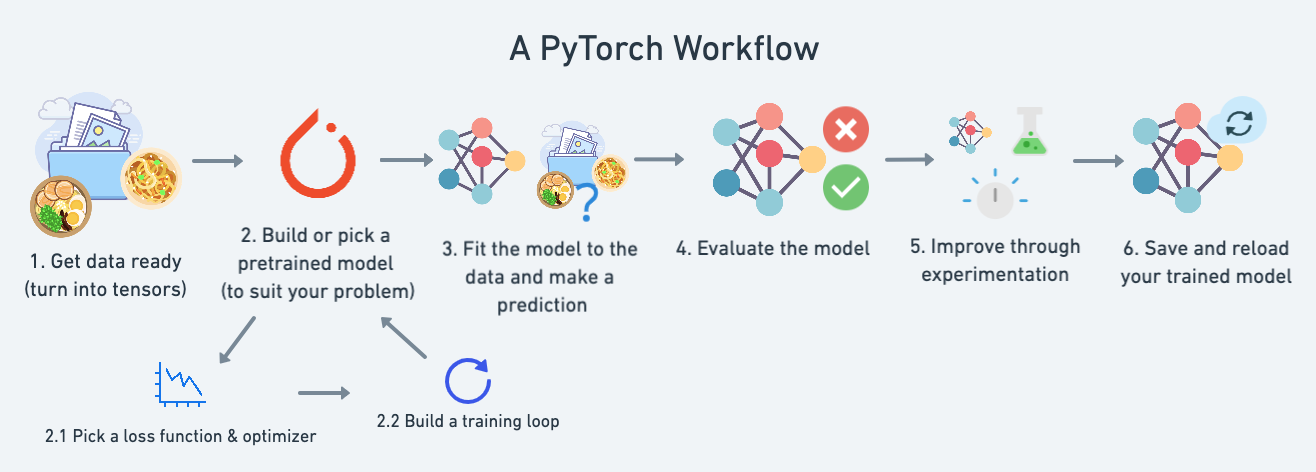

In [ ]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build the model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build the model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.
- Excel spreadsheet
- Images of any kind
- Videos (Youtube has a lot of data...)
- Audio like songs or podcasts
- DNA
- Text

Machine learning is a game of 2 parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known **parameters**.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### Splitting Data into training and test sets

(one of the most important concepts in ML in general)

- Training set
- Validation set (opt)
- Test set

Generalisation - The ability of a ML model to perform well on data it hasn't seen before.

Let's create train and test sets with our data.

In [ ]:
# Create a train-test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualise our data?

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # plot training data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # show legends
  plt.legend(prop={"size": 14});

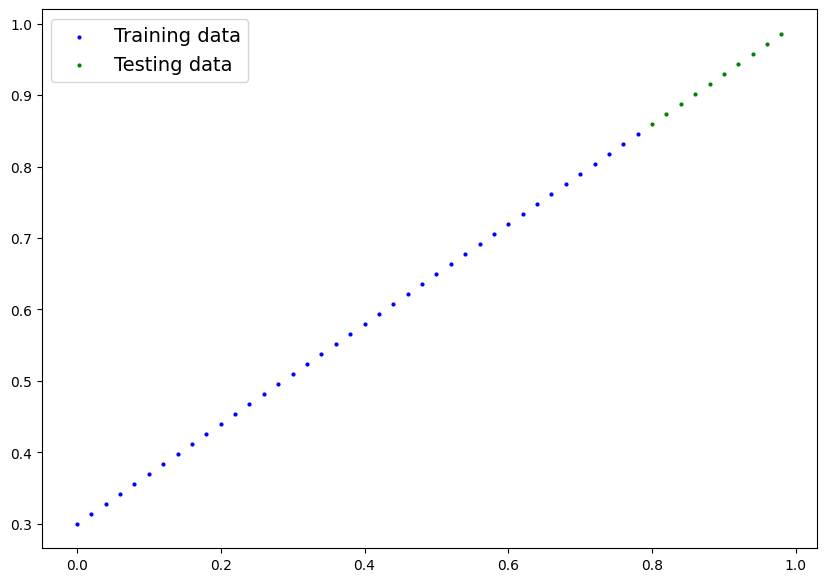

In [ ]:
plot_predictions();

## 2. Build model

OOP in python: https://realpython.com/python3-object-oriented-programming/

What our model does:
- Start with random values (weight and bias)
- Look at training data and adjust the random values to better represent (or get closer to)  the ideal values (the weight & bias values we used to craete data)

How does it do it?

Thorugh 2 main algorithms:
1. Gradient descent: https://www.youtube.com/watch?v=IHZwWFHWa-w&pp=0gcJCfwAo7VqN5tD
2. Backpropagation: https://www.youtube.com/watch?v=Ilg3gGewQ5U&vl=en

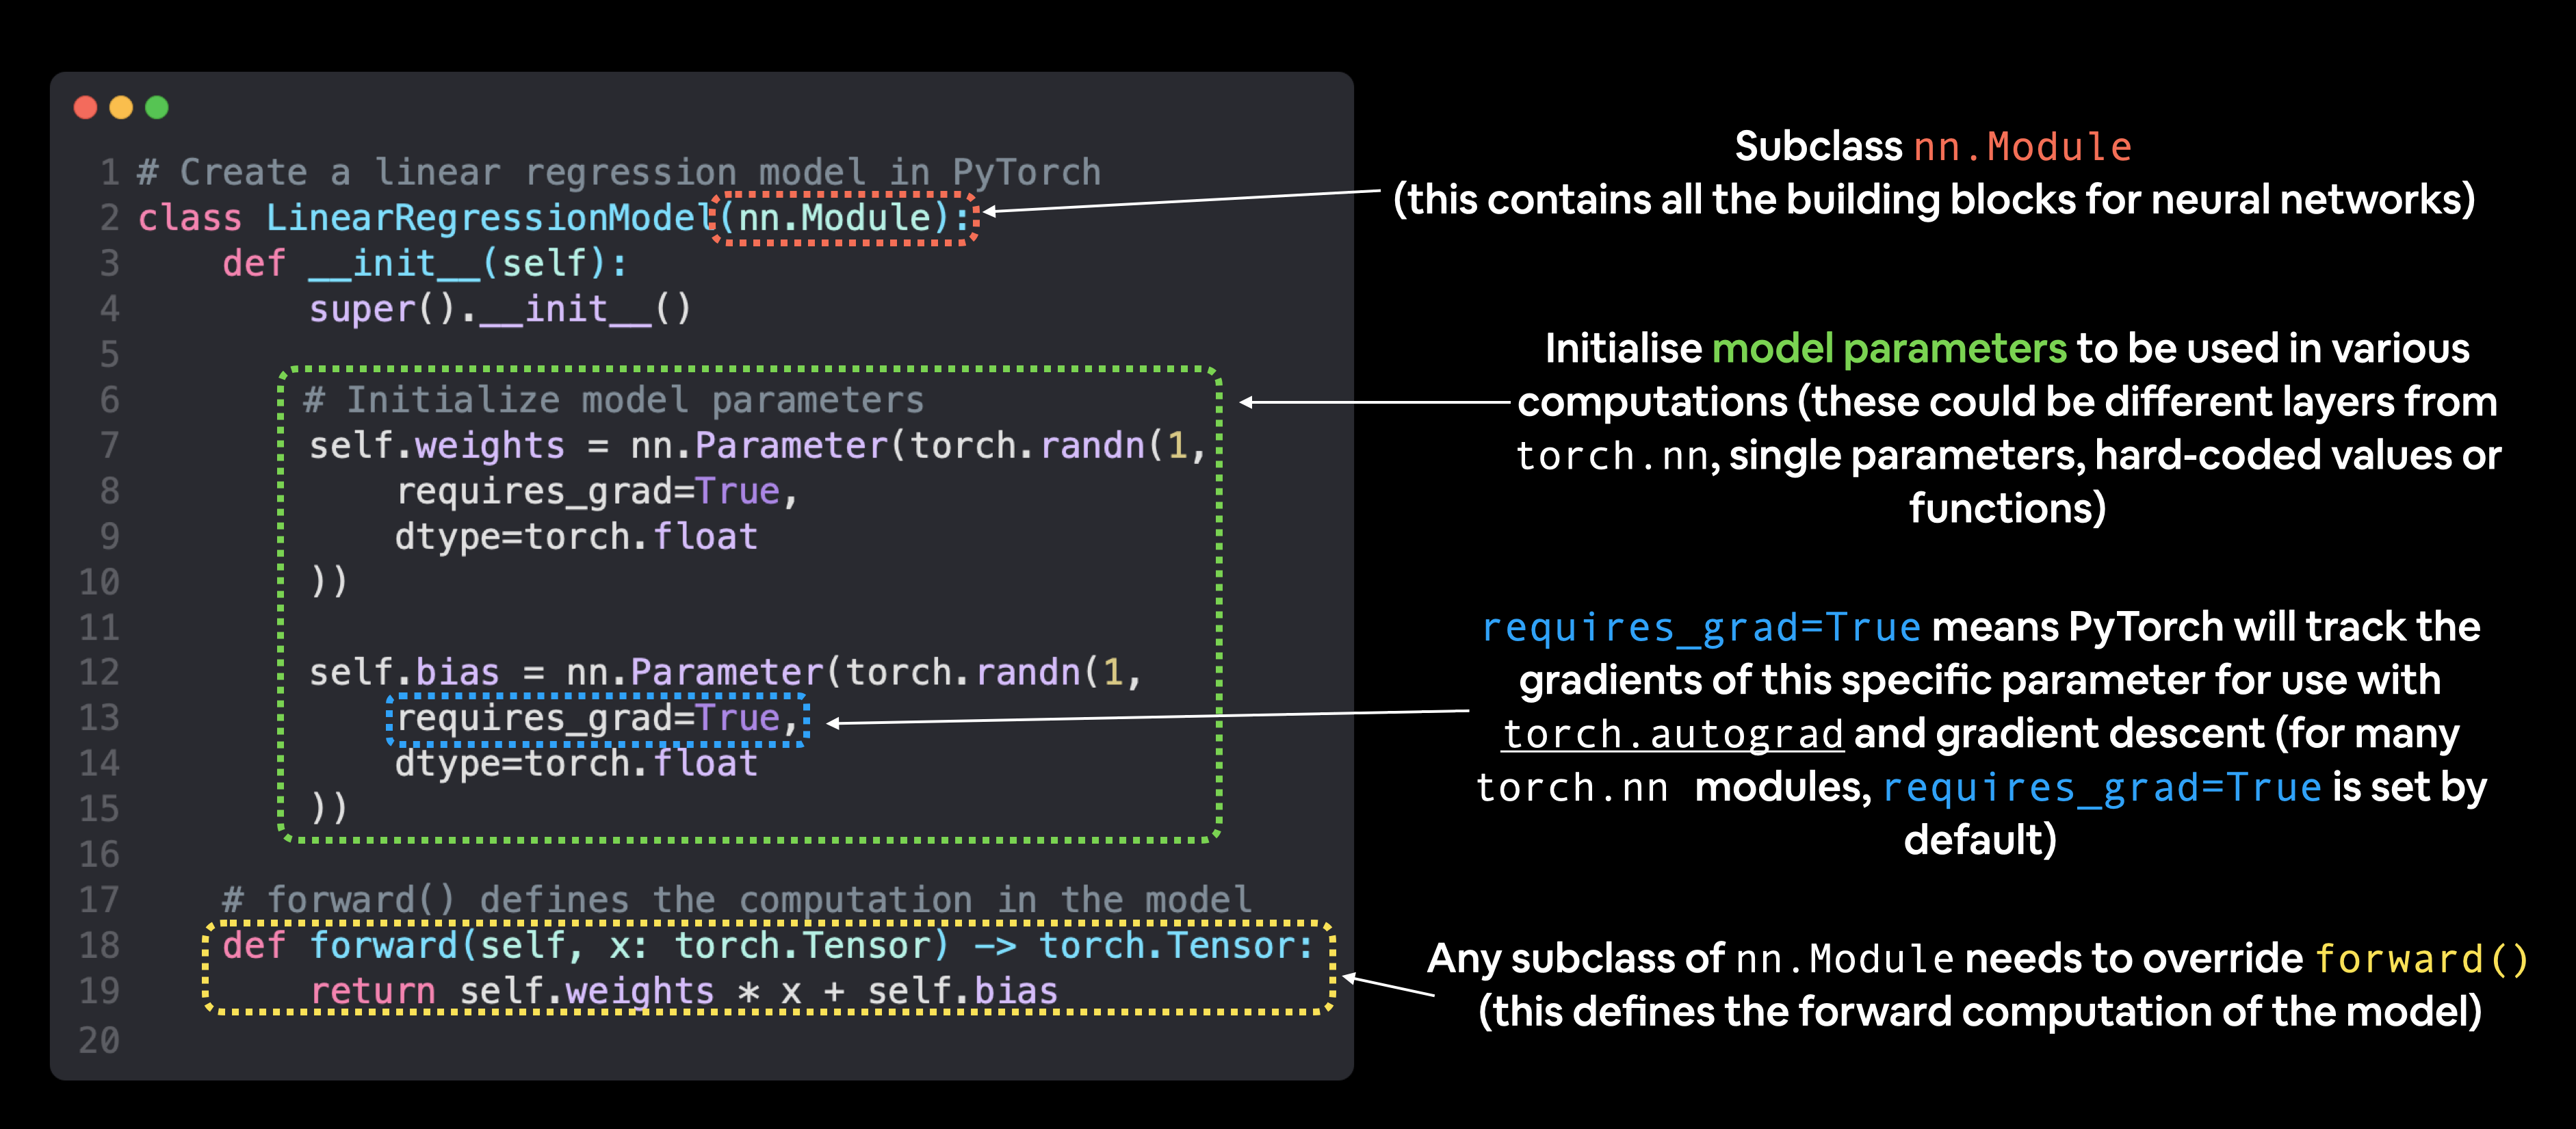

In [ ]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module):  # -> almost everything in Pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # < PyTorch loves datatype torch.float32

    self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and try to adjust it to the ideal bias
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # < PyTorch loves datatype torch.float32


    # forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

- `torch.nn`: contains all of the buildings for computationl graphs (a neural network)
- `torch.nn.Parameter`: what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
- `torch.nn.Module`: The base class for all neural network modules, if you subclass it, you should overwrite forward() https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html
- `torch.optim`: This is where the optimisers in Pytorch live, they will help with gradient descent https://pytorch.org/docs/stable/optim.html
- `def forward()`: All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

See more of these essential modules via PyTorch cheatsheet: https://pytorch.org/tutorials/beginner/ptcheat.html

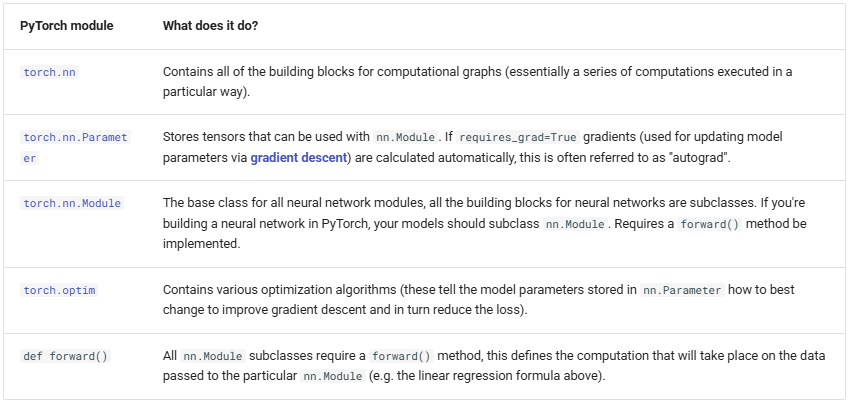

### Checking the contents of our PyTorch model

Let's see what's inside our created model...

So we can check our model parameters or what's inside our model using `.parameters()`

In [ ]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.



In [ ]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [ ]:
# make predictions with model
with torch.inference_mode(): # turns off gradient tracking
  y_preds = model_0(X_test)

# # you can also do something similar with torch.no_grad(), however, torch.inference_moide() is preferred
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference_mode() : https://x.com/PyTorch/status/1437838236529868803
https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html

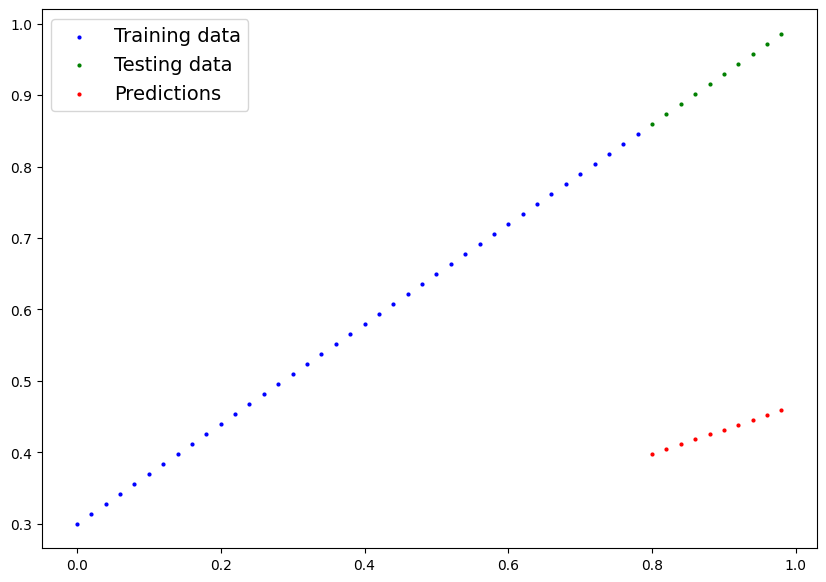

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other word from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your model's predictions are is to use loss functions.

- Note: Loss function may also be called cost function or criterion in different areas.

Things we need to train:
- **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
https://docs.pytorch.org/docs/stable/nn.html#loss-functions
- **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weights and bias) to improve the loss function.
https://pytorch.org/docs/stable/optim.html
  - Inside the optimizer you'll often have to set two parameters:
    - `params`: the model parameters you'd like to optimize, for example, `params=model_0.parameters()`
    - `lr` (learning rate): the learning rate is a hyperparameter that defines hoe big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch we need:
- a training loop
- a testing loop

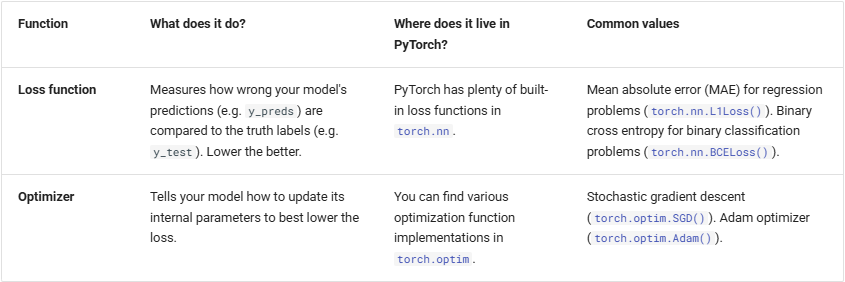

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Set up a loss_function
loss_fn = nn.L1Loss()

# set up an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate (most imp hyperparameter you can set)

**Q**: Which loss function and optimizer should I use?

**A**: This will be problem specific. But with experience, you'll get an idea of what works and what doesn't whitha particular problem set.

For example, for a regression problem (like ours), a loss function of `nn.L1loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat you'll likely want to use a loss function of `nn.BELoss()` (Binary cross entropy loss)

### Building a training loop (and a testing loop) in Pytorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's forward function) i.e. forward propagation, to make predictions on data
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad (zero the gradients of the optimizer)
4. Loss backward - move backwards through the network to calculate the gradients of each of the parmeters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

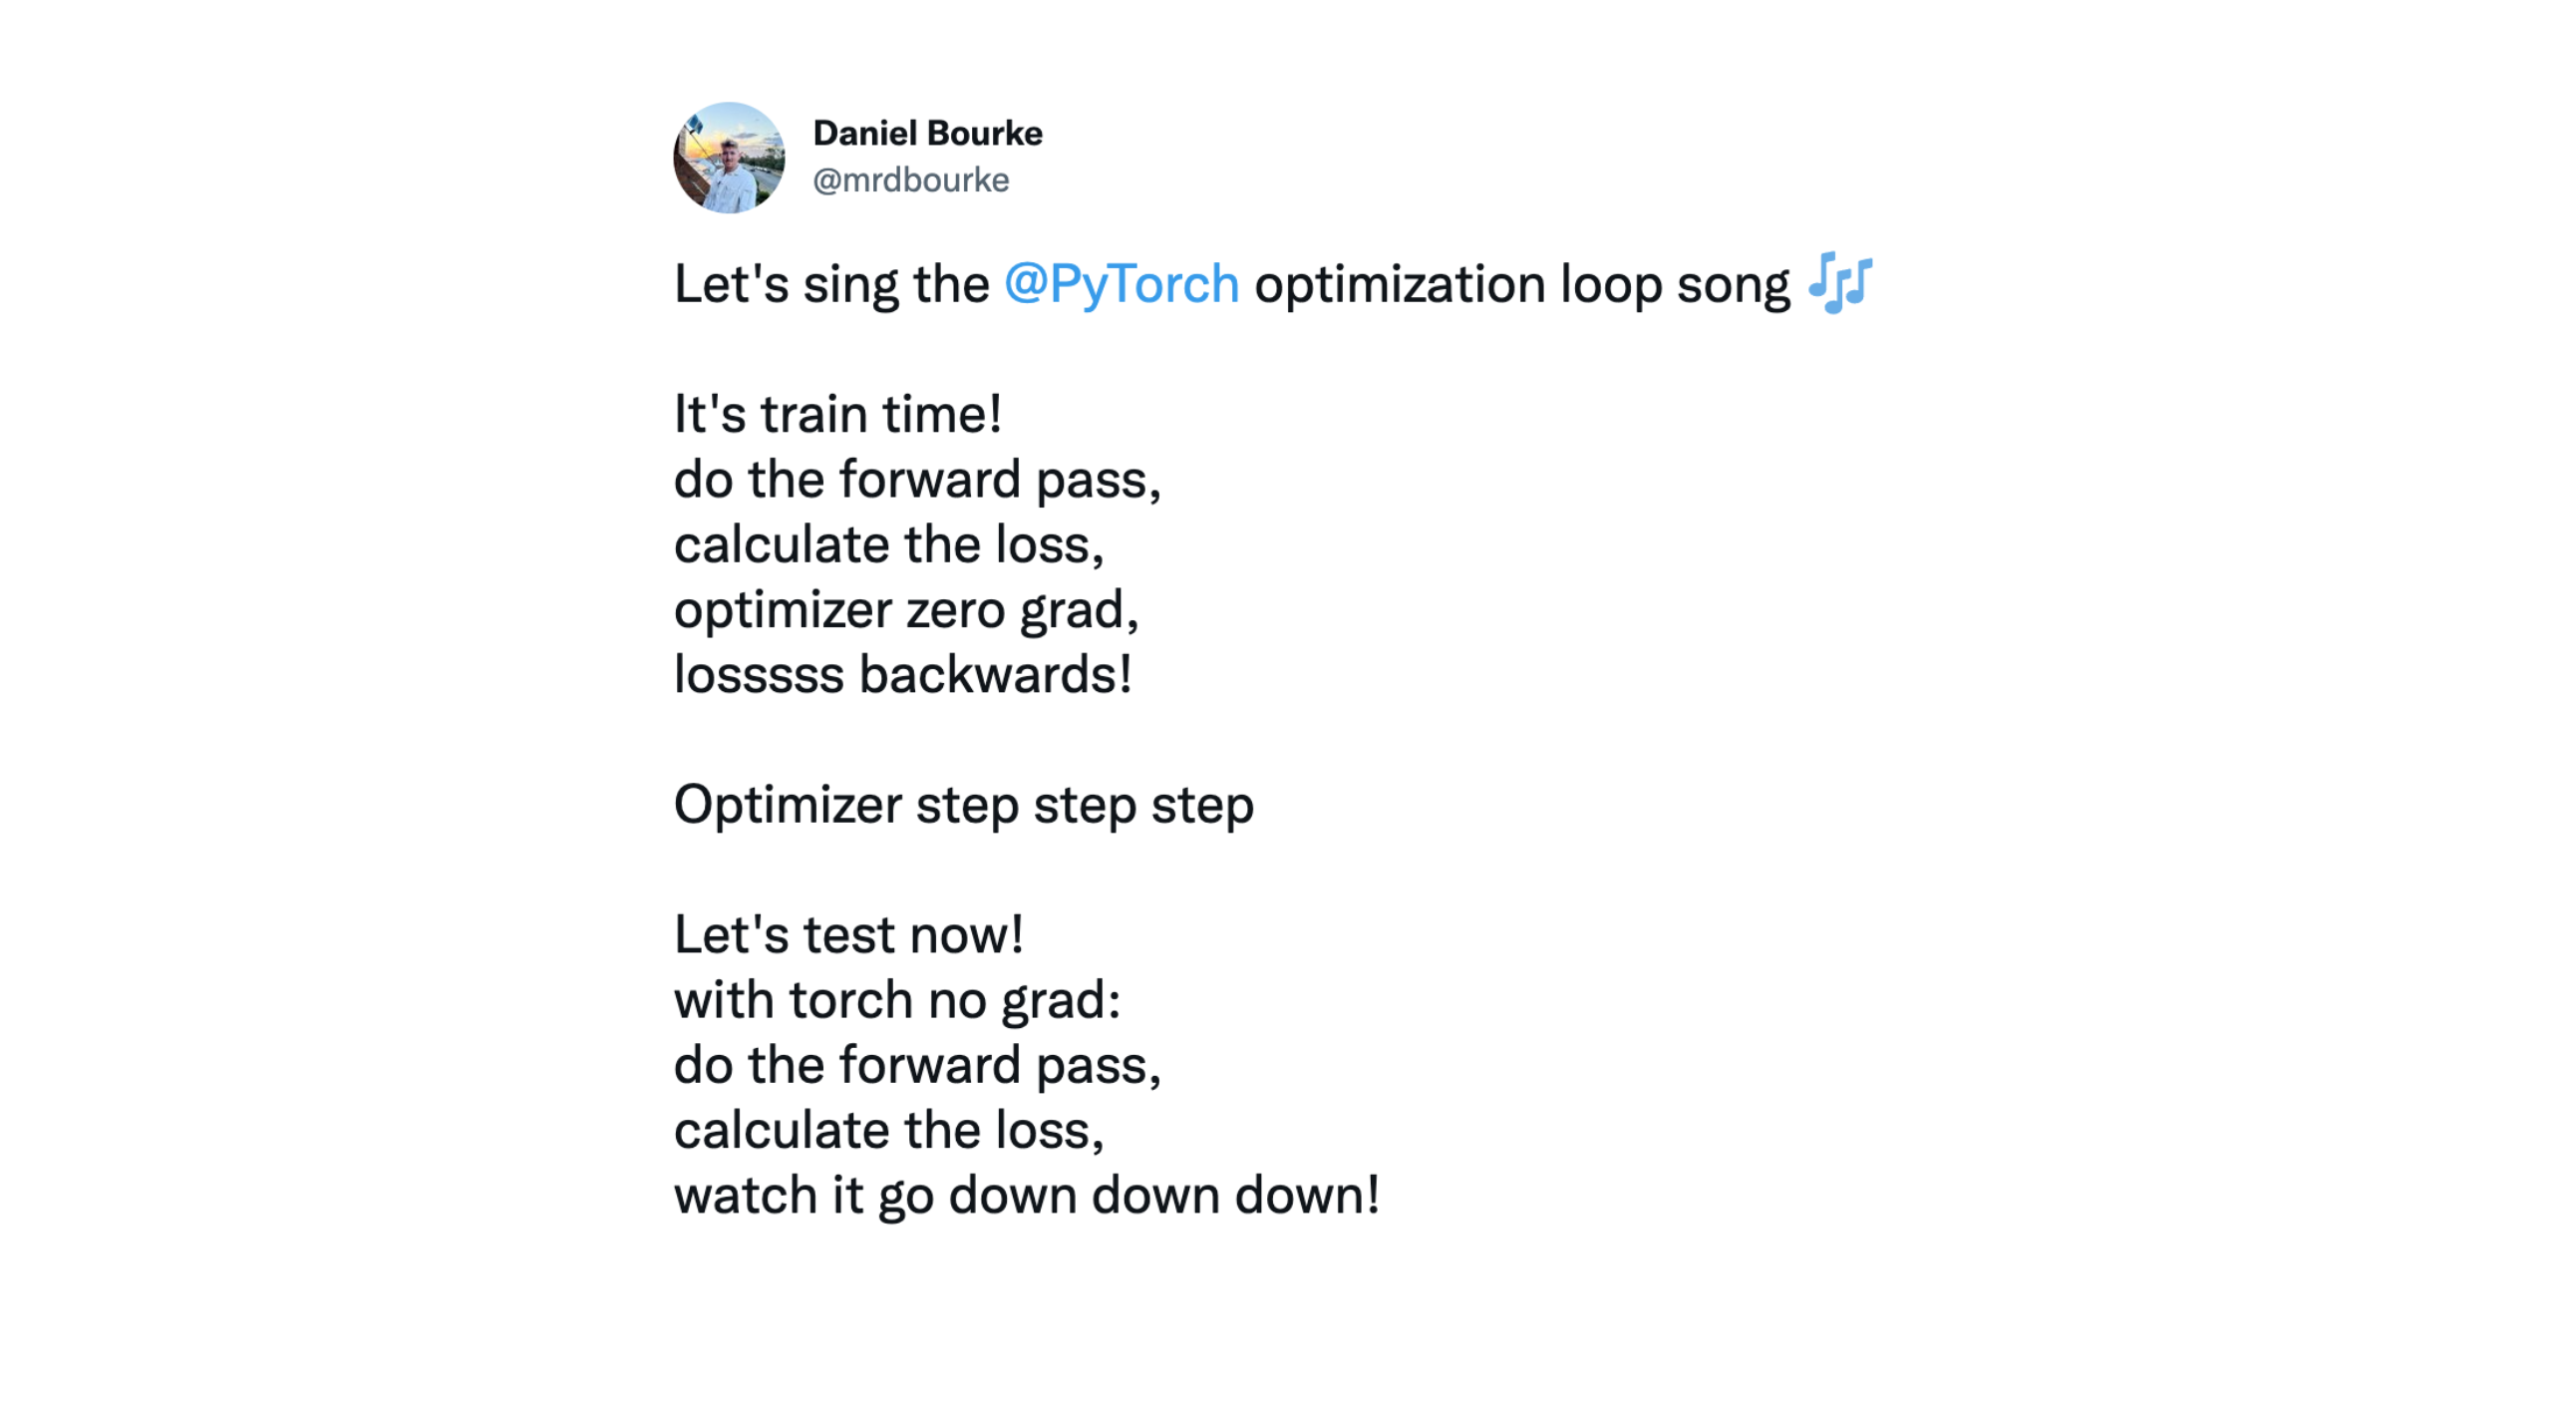

In [ ]:
torch.manual_seed(42)

# an epoch is one loop through the data...
epochs = 200

# track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. loop through the data
for epoch in range(epochs):

  # set the model to training mode
  model_0.train()  # train mode in Pytorch sets all parameters that require gradients to require gradients

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backpropogation to the loss with respect to the parameters of the model
  loss.backward()

  # 5. step the optimiser (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so.. we have to zero them in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing  (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking and a couple more things behind the scene
    # 1. forward pass
    test_pred = model_0(X_test)

    # 2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # print out whats happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

    # print out model state_dict() (params)
    print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [ ]:
import numpy as np
torch.tensor(loss_values).numpy()

array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

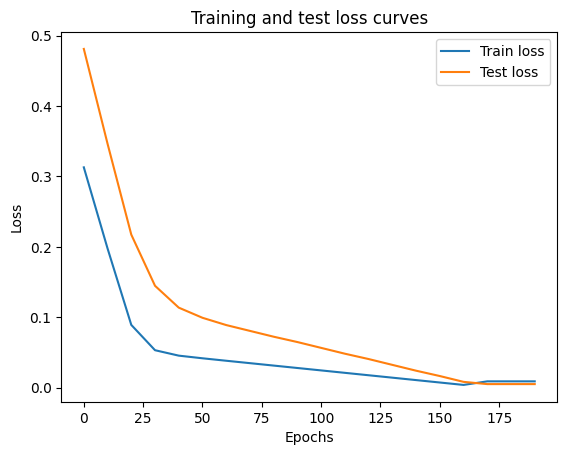

In [ ]:
# plot the loss curves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

y_preds_new

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
weight, bias

(0.7, 0.3)

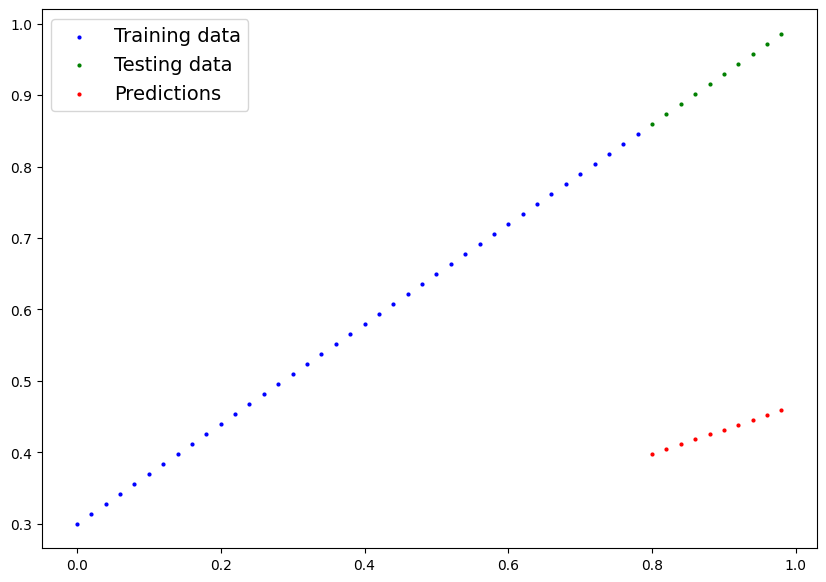

In [ ]:
plot_predictions(predictions=y_preds)

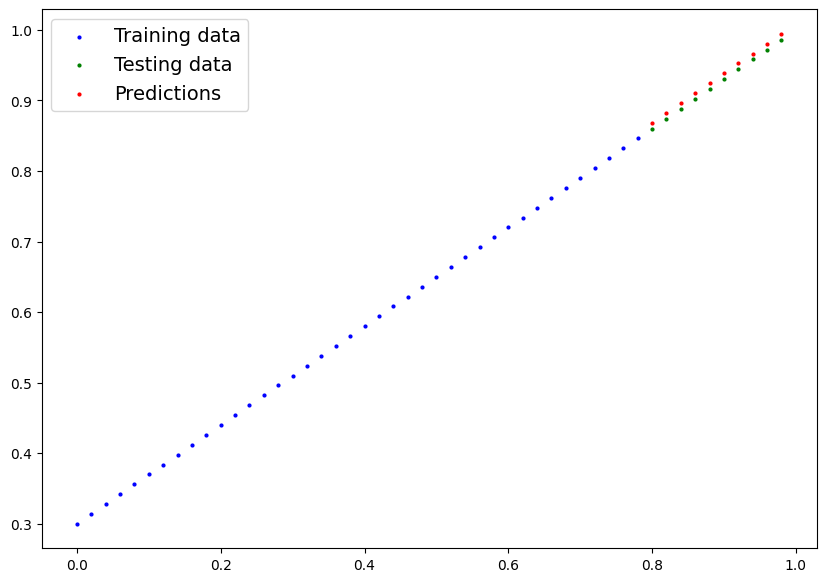

In [ ]:
plot_predictions(predictions=y_preds_new)

## 4. Saving a model in Pytorch

There are 3 main methods you should know about for saving and loading models in Pytorch

1. `torch.save()` - allows you to save a Pytorch object in Python's pickle format
2. `torch.load()` - allows yo to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary (parameters)

PyTorch save and load : https://docs.pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [ ]:
# Saving our pytorch model
from pathlib import Path

# 1. create a model directory
MODEL_PATH =Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## 5. Loading a Pytorch model

Since we saved our model's `state_dict()` rather that the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# to load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Going thorugh all the above steps and putting it in one place.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

In [ ]:
# setup device aignostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### 6.1 Data

In [ ]:
# create some data using linear regression y = w * X + b
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # without unqueeze errors might pop up
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [8]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # plot training data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # show legends
  plt.legend(prop={"size": 14});

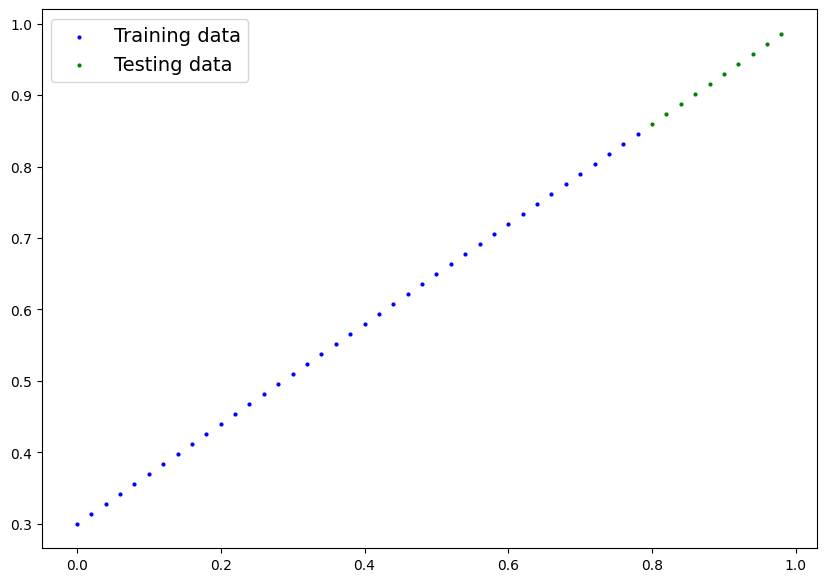

In [ ]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear model

In [ ]:
# create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.linear() for creating model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

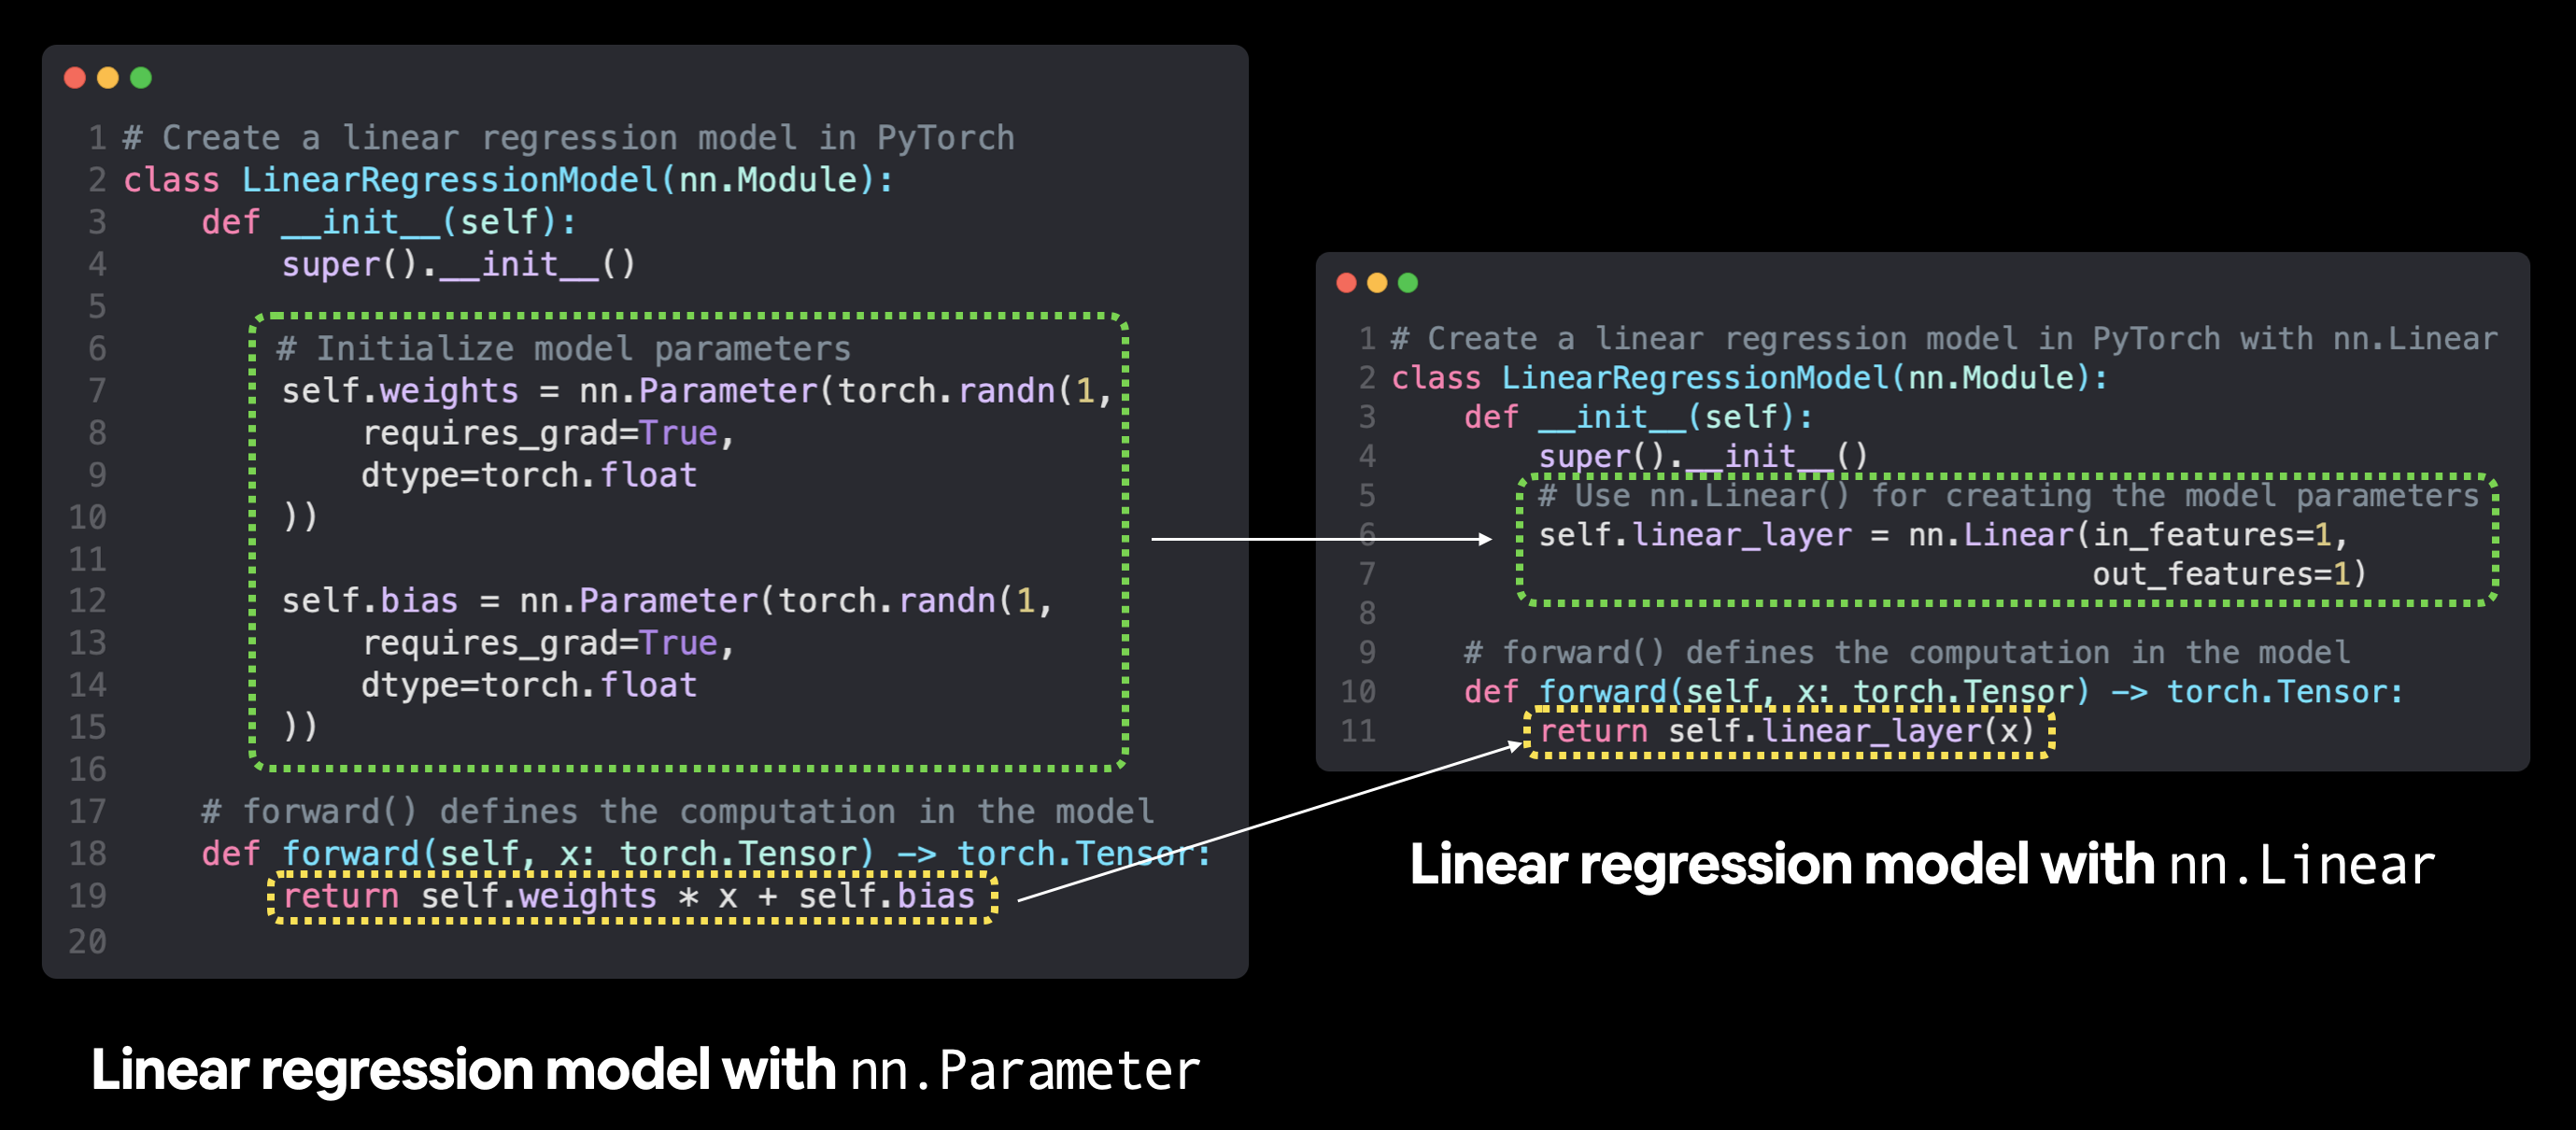

In [ ]:
# check the model's current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

We need:
- loss function
- optimiser
- training loop
- testing loop

In [ ]:
# loss fn
loss_fn = nn.L1Loss()

# optimiser
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

epochs = 200
epoch_count = []
train_loss_values = []
test_loss_values = []

# put data on target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_pred = model_1(X_train)  # forward pass
  loss = loss_fn(y_pred, y_train) # calculate loss
  optimizer.zero_grad() # optimizer zero grad
  loss.backward() # backpropogation
  optimizer.step() # optimizer step

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

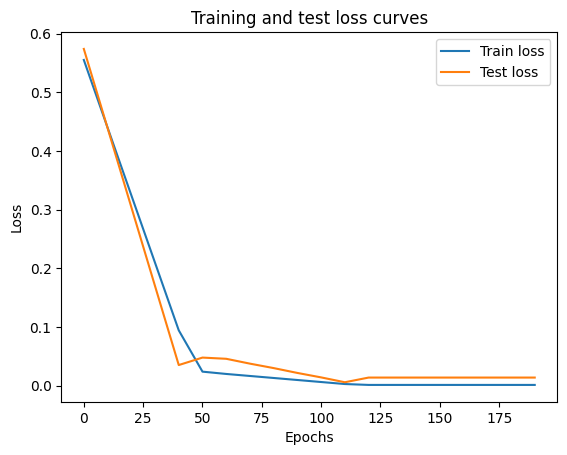

In [ ]:
import numpy as np

# plot the loss curves
plt.plot(epoch_count, torch.tensor(train_loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu(), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### 6.4 Making and evaluation predictions

In [ ]:
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

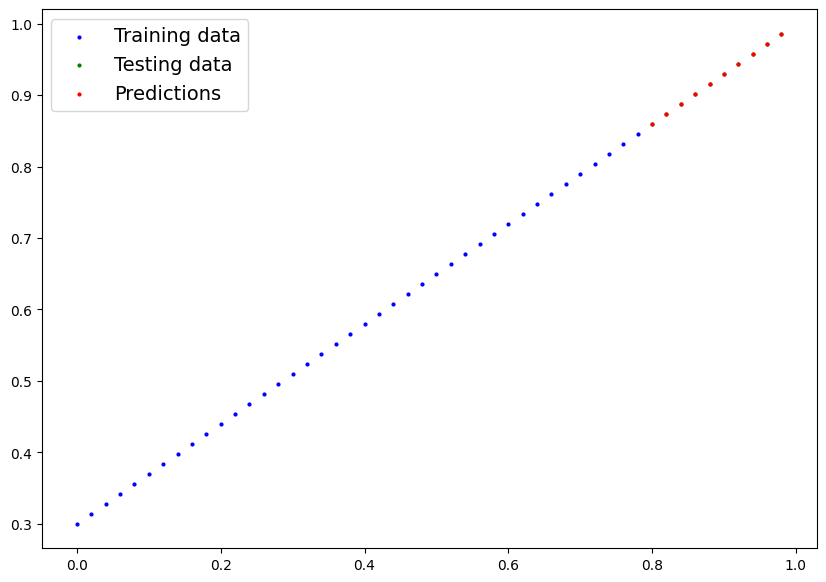

In [ ]:
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a trained model

In [ ]:
from pathlib import Path

# save
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# load
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_1.to(device)

loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
# evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Exercises and Extra-cirriculum

### Exercises
https://www.learnpytorch.io/01_pytorch_workflow/#exercises

All exercises have been inspired from code throughout the notebook.

There is one exercise per major section.

You should be able to complete them by referencing their specific section.

Note: For all exercises, your code should be device agnostic (meaning it could run on CPU or GPU if it's available).

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.6.0+cu124'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Create a straight line dataset using the linear regression formula (weight * X + bias).
- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.

In [5]:
# Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
weight = 0.3
bias = 0.9

start = 0
end = 20
step = 0.2

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.2000],
         [0.4000],
         [0.6000],
         [0.8000],
         [1.0000],
         [1.2000],
         [1.4000],
         [1.6000],
         [1.8000]]),
 tensor([[0.9000],
         [0.9600],
         [1.0200],
         [1.0800],
         [1.1400],
         [1.2000],
         [1.2600],
         [1.3200],
         [1.3800],
         [1.4400]]),
 100,
 100)

In [7]:
# Split the data into 80% training, 20% testing.
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

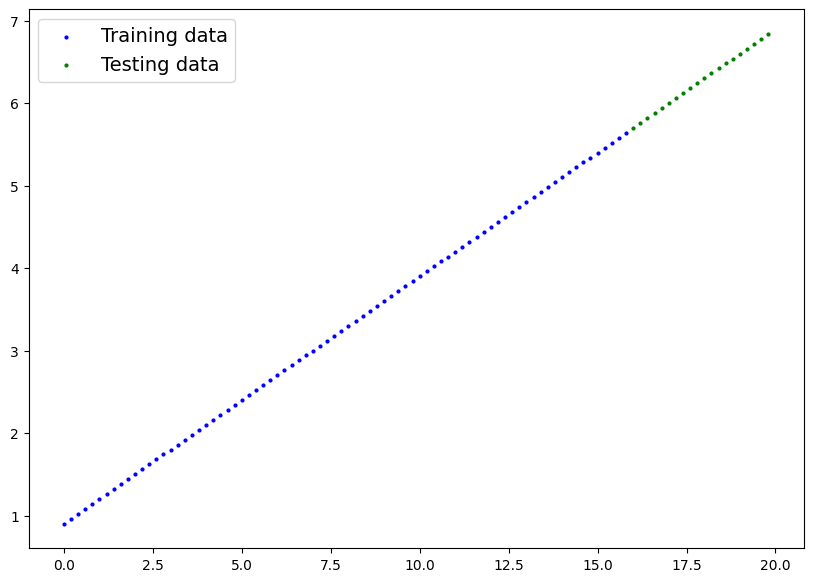

In [9]:
# Plot the training and testing data so it becomes visual.
plot_predictions()

2. Build a PyTorch model by subclassing nn.Module.
- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its state_dict().
- Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

In [10]:
class LinearRegressionModelEx(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model = LinearRegressionModelEx()
model, model.state_dict()

(LinearRegressionModelEx(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.

In [19]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [20]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

epochs = 300
epoch_count = []
train_loss_values = []
test_loss_values = []

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model.train()
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 20 == 0:
    model.eval()
    with torch.inference_mode():
      test_pred = model(X_test)
      test_loss = loss_fn(test_pred, y_test)

      epoch_count.append(epoch)
      train_loss_values.append(loss)
      test_loss_values.append(test_loss)

      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 3.601612091064453 | Test loss: 6.821397304534912
Epoch: 20 | Loss: 0.09854806214570999 | Test loss: 1.3419368267059326
Epoch: 40 | Loss: 0.13464806973934174 | Test loss: 1.2408367395401
Epoch: 60 | Loss: 0.06929810345172882 | Test loss: 1.3711868524551392
Epoch: 80 | Loss: 0.056073930114507675 | Test loss: 1.386910080909729
Epoch: 100 | Loss: 0.20151977241039276 | Test loss: 1.0459635257720947
Epoch: 120 | Loss: 0.16416065394878387 | Test loss: 1.1173216104507446
Epoch: 140 | Loss: 0.14050619304180145 | Test loss: 1.160475492477417
Epoch: 160 | Loss: 0.12219668924808502 | Test loss: 1.192784309387207
Epoch: 180 | Loss: 0.11324872821569443 | Test loss: 1.2067302465438843
Epoch: 200 | Loss: 0.10430081188678741 | Test loss: 1.2206758260726929
Epoch: 220 | Loss: 0.09857692569494247 | Test loss: 1.2288987636566162
Epoch: 240 | Loss: 0.09607710689306259 | Test loss: 1.2313984632492065
Epoch: 260 | Loss: 0.09357728809118271 | Test loss: 1.233898401260376
Epoch: 280 | Loss: 0.

4. Make predictions with the trained model on the test data.
- Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [21]:
with torch.inference_mode():
  y_preds = model(X_test)

y_preds

tensor([[5.5332],
        [5.5912],
        [5.6493],
        [5.7074],
        [5.7654],
        [5.8235],
        [5.8816],
        [5.9396],
        [5.9977],
        [6.0558],
        [6.1138],
        [6.1719],
        [6.2300],
        [6.2880],
        [6.3461],
        [6.4042],
        [6.4622],
        [6.5203],
        [6.5784],
        [6.6364]], device='cuda:0')

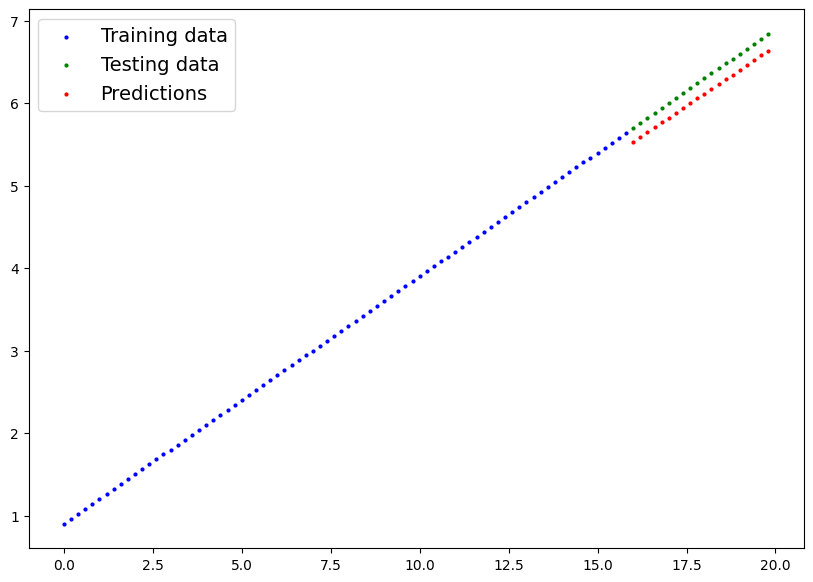

In [22]:
plot_predictions(predictions=y_preds.cpu())

5. Save your trained model's state_dict() to file.
- Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [24]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_2.pth


In [25]:
loaded_model = LinearRegressionModelEx()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model.to(device)

loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.2903]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8878], device='cuda:0'))])

In [26]:
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

### Extra-cirriculum
https://www.learnpytorch.io/01_pytorch_workflow/#extra-curriculum